In [1]:
import pandas, numpy as np
from qiskit import QuantumCircuit, Aer, execute
import mat2qubit as m2q
from openfermion import QubitOperator
import itertools

from __future__ import division, print_function
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import scipy.linalg as sla

import cmath

import matplotlib.cm as cm 

## Error Bounding

Say we want to approximate our exact time-evolution operator $U(t)$ with an approximate Trotter scheme $\tilde{U}(t)$. For a bounded error, $||U(t)-\tilde{U}(t)||$, what circuit depth is required for second-quantisation vs. Hermite encodings?

Let us consider second-order Trotterization, 
$$ \tilde{U}(t) = \left[ \left(e^{-iH_1\frac{t}{2r}}\cdots e^{-iH_L\frac{t}{2r}} \right)^{r}  
\left(e^{-iH_L\frac{t}{2r}}\cdots e^{-iH_1\frac{t}{2r}} \right)^{r} \right]
$$

as it is nearly as simple as first-order Trotterization, but its error scales as $O(dt^3)$ rathern than $O(dt^2)$.

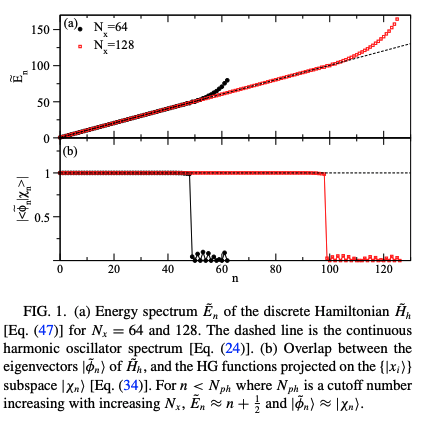

In [2]:
from IPython.display import Image
Image(filename="Phase_I/Outputs/Macridin_Fig1_discretization_overlap.png")

### 1. Creating the Position Basis

We have our discrete basis $\{|x_i\rangle\}$ with $i\in[-\frac{N_x}{2},\frac{N_x}{2}-1]$ and $x_i=i\Delta$ where $\Delta=\sqrt{\frac{2\pi}{N_x}}$

We represent the $|x_i\rangle$ with typical column vectors, e.g.
$$
|x_{-\frac{N_x}{2}}\rangle=
\begin{pmatrix}
1 \\
0 \\ 
0 \\
\vdots \\
\end{pmatrix},
|x_{\frac{N_x}{2}-1}\rangle=
\begin{pmatrix}
0 \\
0 \\ 
\vdots \\
1
\end{pmatrix}
$$

In [3]:
def create_pos_basis(n_x):
    num_states = pow(2,n_x)
    print("Total number of states:", num_states, "\n")
    pos_basis_matrix = np.zeros((num_states,num_states))
    delta=np.sqrt(2*np.pi/num_states)
            
    for i in range(num_states):
        for j in range(-int((num_states/2)),int((num_states/2))):
            k=j+(num_states/2)
            x_j = j*delta
            if k==i:
                pos_basis_matrix[i][i] = x_j
                
    return pos_basis_matrix

In [4]:
n_1=6
n_2=7
n64_pos_rep = np.array(create_pos_basis(n_1))
print(n64_pos_rep, "\n\n")
print("n64_pos_basis[:,0] =",n64_pos_rep[:,0]) # First Column

n128_pos_rep = np.array(create_pos_basis(n_2))


n4_pos_rep = np.array(create_pos_basis(2))
n8_pos_rep = np.array(create_pos_basis(3))
n16_pos_rep = np.array(create_pos_basis(4))
n32_pos_rep = np.array(create_pos_basis(5))

Total number of states: 64 

[[-10.0265131    0.           0.         ...   0.           0.
    0.        ]
 [  0.          -9.71318456   0.         ...   0.           0.
    0.        ]
 [  0.           0.          -9.39985603 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   9.0865275    0.
    0.        ]
 [  0.           0.           0.         ...   0.           9.39985603
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    9.71318456]] 


n64_pos_basis[:,0] = [-10.0265131   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          

### 2. Creating the Momentum Basis

We create the momentum basis using a discrete Fourier Transformation:
$$ P|x_j\rangle = 
$$

In [5]:
def create_mom_basis(n_x):
    num_states = pow(2,n_x)
    delta = np.sqrt(2*np.pi/num_states)
    pos_basis = np.identity(num_states)
    mom_basis_dict = {}
    for j in range(-int((num_states/2)),int((num_states/2))): # Calculate how P acts on all x_j states
        x_j = j*delta
        for m in range(-int((num_states/2)),int((num_states/2))): # FT to momentum space
            p_m = m*delta
            factor1 = p_m*(1/np.sqrt(num_states))*np.exp(-complex(0,1)*x_j*p_m)
            for i in range(-int((num_states/2)),int((num_states/2))): # FT back to position space
                x_i = i*delta
                factor2 = (1/np.sqrt(num_states))*np.exp(complex(0,1)*x_i*p_m)
        
                factor3 = int(i+(num_states/2))
                if i == -int((num_states/2)):
                    mom_basis_dict[x_j] = factor1*factor2*pos_basis[:,factor3]
                else:
                    mom_basis_dict[x_j] += factor1*factor2*pos_basis[:,factor3]  
                    
    
    mom_basis_rep  = []
    for key in mom_basis_dict:
        #print(mom_basis_dict[key])
        mom_basis_rep.append(mom_basis_dict[key])
    mom_basis_rep = np.array(mom_basis_rep)
    mom_basis_rep = mom_basis_rep.transpose()
    
    
    
    mom_rep = np.zeros((num_states,num_states), dtype='complex')
    for i in range(-int((num_states/2)),int((num_states/2))): # looping over discrete points
        k=int(i+(num_states/2)) # matrix index
        x_i = i*delta
        for j in range(-int((num_states/2)),int((num_states/2))): # looping over discrete points
            l=int(j+(num_states/2)) # matrix index
            x_j = j*delta
            for m in range(-int((num_states/2)),int((num_states/2))):
                p_m = m*delta
                mom_rep[k][l] += (1/num_states)*p_m*np.exp(-complex(0,1)*(x_j-x_i)*p_m)
        
    
    #return mom_basis_rep
    return mom_rep


In [6]:
n64_mom_rep = create_mom_basis(n_1)
#print(n64_mom_basis)
n128_mom_rep = create_mom_basis(n_2)

n4_mom_rep = create_mom_basis(2)
n8_mom_rep = create_mom_basis(3)
n16_mom_rep = create_mom_basis(4)
n32_mom_rep = create_mom_basis(5)

### 3. Constructing the Creation and Annihilation Operators

Now that we have X and P operators written in the position basis, we can construct the creation and annihilation operatos using
$$ a = \frac{1}{\sqrt{2}}\left(X+iP \right)\\
a^\dagger = \frac{1}{\sqrt{2}}\left(X-iP \right)
$$

In [7]:
def create_ladder_ops(pos,mom):
    a = np.sqrt(1/2)*(pos+complex(0,1)*mom)
    a_dagger = np.sqrt(1/2)*(pos-complex(0,1)*mom)
    return a, a_dagger

In [8]:
n64_a, n64_a_dagger = create_ladder_ops(n64_pos_rep, n64_mom_rep)
n128_a, n128_a_dagger = create_ladder_ops(n128_pos_rep, n128_mom_rep)

n4_a, n4_a_dagger = create_ladder_ops(n4_pos_rep, n4_mom_rep)
n8_a, n8_a_dagger = create_ladder_ops(n8_pos_rep, n8_mom_rep)
n16_a, n16_a_dagger = create_ladder_ops(n16_pos_rep, n16_mom_rep)
n32_a, n32_a_dagger = create_ladder_ops(n32_pos_rep, n32_mom_rep)

### 4. Building the Hamiltonian

We write 
$$ H = a^\dagger a +\frac{1}{2}
$$

In [9]:
def create_Hamiltonian(n_x,a,ad):
    num_states = pow(2,n_x)
    H = np.matmul(ad,a)+0.5*np.identity(num_states)
    return H

def create_ham_2(x,p):
    H = .5*(np.matmul(x,x)+np.matmul(p,p))
    return H

In [10]:
n64_H = create_Hamiltonian(n_1,n64_a,n64_a_dagger)
n128_H = create_Hamiltonian(n_2,n128_a,n128_a_dagger)

n4_H = create_Hamiltonian(2,n4_a,n4_a_dagger)
n8_H = create_Hamiltonian(3,n8_a,n8_a_dagger)
n16_H = create_Hamiltonian(4,n16_a,n16_a_dagger)
n32_H = create_Hamiltonian(5,n32_a,n32_a_dagger)

### 5. Calculating the Eigenvalues

In [11]:
# Calculate the energy values for the discretised Hamiltonian
evals4, evecs4 = sla.eigh(n4_H)
evals8, evecs8 = sla.eigh(n8_H)
evals16, evecs16 = sla.eigh(n16_H)
evals32, evecs32 = sla.eigh(n32_H)
evals64, evecs64 = sla.eigh(n64_H)
evals128, evecs128 = sla.eigh(n128_H)
print(evals64, "\n\n")
print(evals128, "\n\n")


# exact = the exact energy values for the normal QHO Hamiltonian: E = n+.5
exact = [(k +.5) for k in range(128+10)] 
print(np.round(exact,6), "\n\n")

[  0.5          1.5          2.5          3.5          4.5
   5.5          6.5          7.5          8.5          9.5
  10.5         11.5         12.5         13.5         14.5
  15.5         16.5         17.5         18.5         19.5
  20.5         21.5         22.5         23.5         24.5
  25.5         26.5         27.5         28.5         29.5
  30.50000001  31.49999989  32.49999938  33.49999634  34.50000197
  35.46436863  35.50254214  36.50028301  37.50048188  38.50019834
  39.5019249   40.50376571  41.50860129  42.50821929  43.53059837
  44.55250209  45.60181537  46.629508    47.73719593  48.87665679
  50.09953008  51.36864602  52.57583935  54.03793015  55.76151861
  57.81370972  59.00012655  60.90326737  64.20085943  67.79511271
  68.67094657  71.53442255  85.58028914 141.44692482] 


[  0.5          1.5          2.5          3.5          4.5
   5.5          6.5          7.5          8.5          9.5
  10.5         11.5         12.5         13.5         14.5
  15.5         1

In [22]:
for i,val in enumerate(evals128):
    ex = exact[i]
    err = np.abs(ex-val)
    print(f'{i}:', ex, val, err)

0: 0.5 0.49999999999975536 2.4463764347615324e-13
1: 1.5 1.49999999999972 2.799982468104645e-13
2: 2.5 2.499999999999739 2.611244553918368e-13
3: 3.5 3.4999999999997415 2.5845992013273644e-13
4: 4.5 4.499999999999715 2.851052727237402e-13
5: 5.5 5.499999999999729 2.708944180085382e-13
6: 6.5 6.499999999999734 2.6556534749033744e-13
7: 7.5 7.499999999999749 2.5135449277513544e-13
8: 8.5 8.499999999999746 2.540190280342358e-13
9: 9.5 9.499999999999783 2.1671553440683056e-13
10: 10.5 10.499999999999787 2.1316282072803006e-13
11: 11.5 11.499999999999766 2.3447910280083306e-13
12: 12.5 12.499999999999751 2.4868995751603507e-13
13: 13.5 13.499999999999782 2.184918912462308e-13
14: 14.5 14.4999999999998 2.007283228522283e-13
15: 15.5 15.499999999999794 2.0605739337042905e-13
16: 16.5 16.499999999999808 1.9184653865522705e-13
17: 17.5 17.49999999999981 1.8829382497642655e-13
18: 18.5 18.4999999999998 1.9895196601282805e-13
19: 19.5 19.49999999999978 2.2026824808563106e-13
20: 20.5 20.499999999

### 6. Making the Plot

In [25]:
def make_plot(evals64, evals128):
    # Define the data
    n64_vals = [k for k in range(64)]
    n128_vals = [k for k in range(128)]
    
    n4_vals = [k for k in range(4)]
    n8_vals = [k for k in range(8)]
    n16_vals = [k for k in range(16)]
    n32_vals = [k for k in range(32)]

    # Analytic Solution
    x1 = np.array([k for k in range(128+10)]) 
    y1 = np.array(exact)

    # Discretized Solution
    x2 = np.array(n64_vals)
    y2 = np.array(evals64)

    x3 = np.array(n128_vals)
    y3 = np.array(evals128)
    
    x4 = np.array(n4_vals)
    y4 = np.array(evals4)
    
    x5 = np.array(n8_vals)
    y5 = np.array(evals8)
    
    x6 = np.array(n16_vals)
    y6 = np.array(evals16)
    
    x7 = np.array(n32_vals)
    y7 = np.array(evals32)
    # y3 = np.array(guess)

    # Create the grid of plots
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))

    # Plot the raw data
    axs.plot(x1, y1, 'bo', markersize=4, label='$n+0.5$')
    axs.plot(x3, y3, 'g^', markersize=4, label='$N_x=128$')
    axs.plot(x2, y2, 'r^', markersize=4, label='$N_x=64$')
    axs.plot(x7, y7, 'y^', markersize=4, label='$N_x=32$')
    axs.plot(x6, y6, 'b^', markersize=4, label='$N_x=16$')
    axs.plot(x5, y5, 'go', markersize=4, label='$N_x=8$')
    axs.plot(x4, y4, 'ro', markersize=4, label='$N_x=4$')
    
    
    # axs.set_ylim(.1, 100)
    # axs.set_yscale('log')

    axs.set_xlabel('n')
    axs.set_ylabel('$\~{E}_n$')
    axs.set_title('Discrete vs. Analytic Energy Comparison')
    axs.legend()
    plt.savefig('Error_bounding_plots/Recreate_Macridin.jpg')
    
    return 

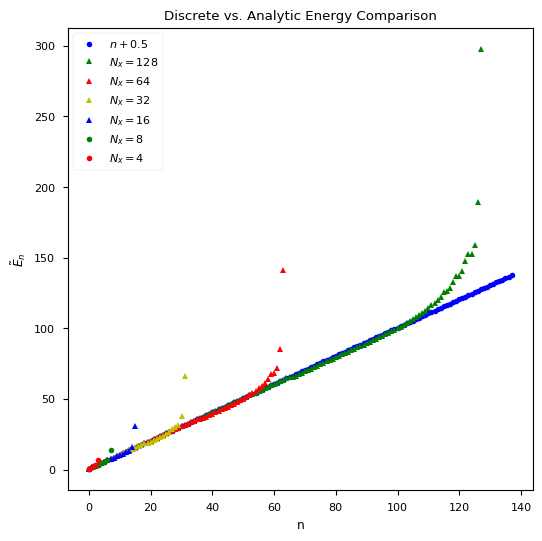

In [26]:
make_plot(evals64, evals128)

In [41]:
def determine_max_n(threshold=1e-6):
    '''
    For a given error threshold, determine the largest N_ph that can be achieved for each number of qubits
    '''
    set_evals = [evals4, evals8, evals16, evals32, evals64, evals128]
    max_n = np.array([])
    for i, evals_list in enumerate(set_evals):
        for j, evals in enumerate(evals_list):
            exact_val = exact[j]
            approx = evals
            error = np.abs(exact_val-approx)
            if error>threshold:
                max_n = np.append(max_n, j-1)
                break
    
    return max_n

In [61]:
max_n = determine_max_n()
print(max_n)

[  2.   6.  13.  27.  53. 105.]


In [48]:
# import lsqfit
from scipy.optimize import curve_fit

# Define the exponential function to fit the data
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

In [72]:
def N_X_plot():
    
    errors = [1,1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    
    x_labels = ["4", "8", "16", "32", "64", "128"]
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    x1 = np.array([1,2,3,4,5,6])
    # axs = axs.flatten()
    
    axs.set_title('$N_{ph}$ vs $N_x$')
    axs.set_xticks(range(1,len(x_labels)+1))
    axs.set_xticklabels(x_labels, rotation=0)
    axs.set_xlabel('$N_x$')
    axs.set_ylabel('$N_{ph}$')
    
    cmap = cm.get_cmap('tab10')  # Use matplotlib.cm.get_cmap
    tick_colors = [cmap(j) for j in np.linspace(0, 1, len(errors))]
    markers = ['o', 's', '^', 'D', 'v', '+', 'x']
    
    for i,threshold in enumerate(errors):
        y1 = np.array([])
        y1 = np.append(y1, determine_max_n(threshold))
            
        axs.plot(x1, y1, markers[i], label=f'{threshold}')
            
        if threshold==1e-6:
            # Fit the data with an exponential function 
            popt_exp, _ = curve_fit(exponential, x1, y1) #returns params, cov.
            x_fit = np.linspace(min(x1), max(x1), 100)
            y1_fit = exponential(x_fit, *popt_exp)
            # axs.plot(x_fit, y1_fit, 'r-', label=f'$X$ Exponential Fit: {popt_exp[0]:.2f}e^{popt_exp[1]:.2f}x + {popt_exp[2]:.2f}')
                
               
    
    # axs.legend(title='Error Thresholds')
    legend = axs.legend(title='Error Thresholds', title_fontsize='small')
    axs.set_ylim(-1, 110)
            
    # Show all plots
    plt.tight_layout()
    plt.style.use("seaborn-v0_8-paper")
    save_name = "Error_bounding_plots/Thresholds_plot"
    plt.savefig(save_name)
    plt.show()
    
    return

/var/folders/kx/yxy4c5_x3sndybymyk9qhrbr0000gn/T/ipykernel_1498/729418614.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')  # Use matplotlib.cm.get_cmap


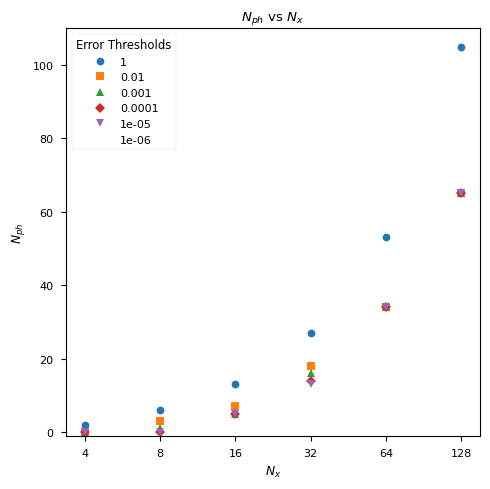

In [73]:
N_X_plot()

## Combining the previous two plots

In [98]:
def combine_plots():
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs = axs.flatten()
    
    
    
    for i in range(2):
        if i==0:
            # Define the data
            n64_vals = [k for k in range(64)]
            n128_vals = [k for k in range(128)]
    
            n4_vals = [k for k in range(4)]
            n8_vals = [k for k in range(8)]
            n16_vals = [k for k in range(16)]
            n32_vals = [k for k in range(32)]

            # Analytic Solution
            x1 = np.array([k for k in range(128+10)]) 
            y1 = np.array(exact)

            # Discretized Solution
            x2 = np.array(n64_vals)
            y2 = np.array(evals64)

            x3 = np.array(n128_vals)
            y3 = np.array(evals128)
    
            x4 = np.array(n4_vals)
            y4 = np.array(evals4)
    
            x5 = np.array(n8_vals)
            y5 = np.array(evals8)
    
            x6 = np.array(n16_vals)
            y6 = np.array(evals16)
    
            x7 = np.array(n32_vals)
            y7 = np.array(evals32)
            # y3 = np.array(guess)

            # Plot the raw data
            axs[i].plot(x1, y1, 'bo', markersize=4, label='$n+0.5$')
            axs[i].plot(x3, y3, 'g^', markersize=4, label='$N_x=128$')
            axs[i].plot(x2, y2, 'r^', markersize=4, label='$N_x=64$')
            axs[i].plot(x7, y7, 'y^', markersize=4, label='$N_x=32$')
            axs[i].plot(x6, y6, 'b^', markersize=4, label='$N_x=16$')
            axs[i].plot(x5, y5, 'go', markersize=4, label='$N_x=8$')
            axs[i].plot(x4, y4, 'ro', markersize=4, label='$N_x=4$')

            axs[i].set_xlabel('n')
            axs[i].set_ylabel('$\~{E}_n$')
            axs[i].set_title('Discrete vs. Analytic Energy Comparison')
            axs[i].legend()
            
        elif i==1:
            errors = [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
            x_labels = ["4", "8", "16", "32", "64", "128"]
            x1 = np.array([1,2,3,4,5,6])
            
            axs[i].set_title('$N_{ph}$ vs $N_x$')
            axs[i].set_xticks(range(1,len(x_labels)+1))
            axs[i].set_xticklabels(x_labels, rotation=0)
            axs[i].set_xlabel('$N_x$')
            axs[i].set_ylabel('$N_{ph}$')
            
            cmap = cm.get_cmap('tab10')  # Use matplotlib.cm.get_cmap
            tick_colors = [cmap(j) for j in np.linspace(0, 1, len(errors))]
            markers = ['^', 's', 'o', 'D', 'v', 'P']
            
            for j,threshold in enumerate(errors):
                y1 = np.array([])
                y1 = np.append(y1, determine_max_n(threshold))
            
                    
                axs[i].plot(x1, y1, markers[j], label=f'{threshold}')
            
                if threshold==1e-6:
                    # Fit the data with an exponential function 
                    popt_exp, _ = curve_fit(exponential, x1, y1) #returns params, cov.
                    x_fit = np.linspace(min(x1), max(x1), 100)
                    y1_fit = exponential(x_fit, *popt_exp)
                    # axs.plot(x_fit, y1_fit, 'r-', label=f'$X$ Exponential Fit: {popt_exp[0]:.2f}e^{popt_exp[1]:.2f}x + {popt_exp[2]:.2f}')
                
               
    
            # axs.legend(title='Error Thresholds')
            legend = axs[i].legend(title='Error Thresholds', title_fontsize='small')
            axs[i].set_ylim(.1, 150)
            axs[i].set_yscale('log')
    
    
    plt.tight_layout()
    plt.style.use("seaborn-v0_8-paper")
    plt.savefig('Error_bounding_plots/Combined_rec_Macridin_Nx_plots')
        
    
    return

/var/folders/kx/yxy4c5_x3sndybymyk9qhrbr0000gn/T/ipykernel_1498/3152759614.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')  # Use matplotlib.cm.get_cmap


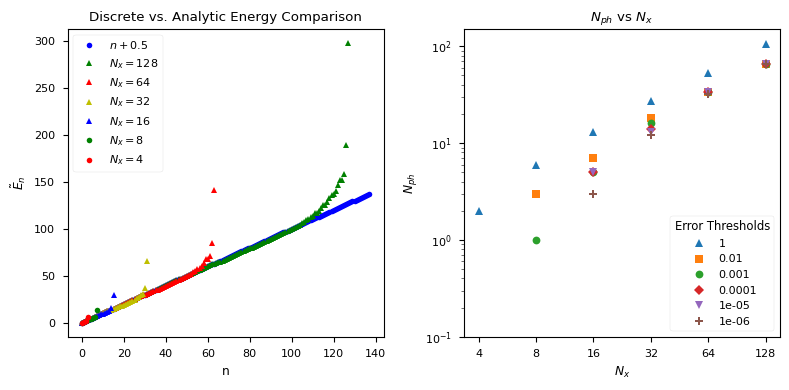

In [99]:
combine_plots()